In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, r2_score, confusion_matrix
from sklearn import svm

from xgboost import XGBClassifier

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

import warnings

%matplotlib inline

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


# Modeling

In [2]:
df = pd.read_csv('../preprocessed_data_classification_Z.csv', index_col=0)

NameError: name 'pd' is not defined

# Baseline Accuracy

In [3]:
score_marked_restaurant_count=df.score.count()

In [4]:
df.groupby('score').count()[['rating']]

,rating
score,
0,4862
1,1744
2,828


In [5]:
score_0_marked_restaurant_count = df[df.score == 0].score.count()
score_0_marked_restaurant_count 

4862

In [6]:
score_1_marked_restaurant_count = df[df.score == 1].score.count()
score_1_marked_restaurant_count 

1744

In [7]:
score_2_marked_restaurant_count = df[df.score == 2].score.count()
score_2_marked_restaurant_count 

828

In [8]:
score_0_percent = (score_0_marked_restaurant_count/score_marked_restaurant_count) * 100
score_0_percent

65.402206080172192

In [9]:
score_1_percent = (score_1_marked_restaurant_count/score_marked_restaurant_count) * 100
score_1_percent

23.459779391982782

In [10]:
score_2_percent = (score_2_marked_restaurant_count/score_marked_restaurant_count) * 100
score_2_percent

11.138014527845035

# Oversampling

Befor re-sampling:
0    4862
1    1744
2     828
Name: score, dtype: int64


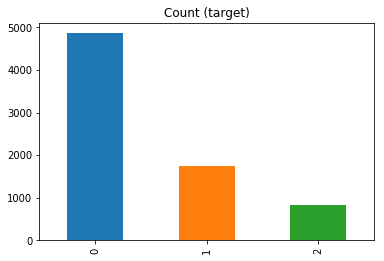

In [11]:
# Class count
count_class_0, count_class_1, count_class_2 = df.score.value_counts()

# Divide by class
df_class_0 = df[df['score'] == 0]
df_class_1 = df[df['score'] == 1]
df_class_2 = df[df['score'] == 2]

print('Befor re-sampling:')
print(df.score.value_counts())

df.score.value_counts().plot(kind='bar', title='Count (target)');

Random over-sampling:
2    4862
1    4862
0    4862
Name: score, dtype: int64


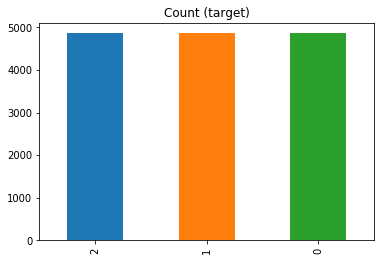

In [12]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_2_over = df_class_2.sample(count_class_0, replace=True)

df_over = pd.concat([df_class_0, df_class_1_over], axis=0)
df_over = pd.concat([df_over, df_class_2_over], axis=0)

print('Random over-sampling:')
print(df_over.score.value_counts())

df_over.score.value_counts().plot(kind='bar', title='Count (target)');

In [13]:
warnings.filterwarnings('ignore')

In [14]:
random_forest = RandomForestClassifier()
extra_tree = ExtraTreeClassifier()
decision_tree = DecisionTreeClassifier()
bagged_tree = BaggingClassifier()
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [ ]:
#multi_naive = MultinomialNB()

In [15]:
X = df.drop(columns=['score'])
y = df['score']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)
data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])
random_forest.fit(X_train_sc, y_train)
data = data.append({'model': 'random_forest',
                        'cross-val': cross_val_score(random_forest, X_train_sc, y_train).mean(),
                        'train': random_forest.score(X_train_sc, y_train),
                        'test': random_forest.score(X_test_sc, y_test)}, ignore_index=True)
data

,model,cross-val,train,test
0,random_forest,0.601615,0.893632,0.605164


In [16]:
pd.Series(y).value_counts()

0    4862
1    1744
2     828
Name: score, dtype: int64

In [17]:
pd.Series(random_forest.predict(X_test_sc)).value_counts(1)

0    0.770307
1    0.162991
2    0.066703
dtype: float64

# Random_forest,extra_tree, decision_tree, bagged_tree, logreg and knn

In [18]:
def scores(models):
    X = df.drop(columns=['score'])
    y = df['score']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = StandardScaler()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [19]:
a = scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [20]:
a

,model,cross-val,train,test
0,"RandomForestClassifier(bootstrap=True, class_w...",0.600718,0.891839,0.590102
1,"ExtraTreeClassifier(class_weight=None, criteri...",0.549418,0.910673,0.549220
2,"DecisionTreeClassifier(class_weight=None, crit...",0.554440,0.910673,0.565896
3,"BaggingClassifier(base_estimator=None, bootstr...",0.599822,0.886457,0.601399
4,"LogisticRegression(C=1.0, class_weight=None, d...",0.644842,0.659013,0.650350
5,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.604126,0.711211,0.617536


In [21]:
  model = PCA()

In [1]:
 X = df.drop(columns=['score'])

NameError: name 'df' is not defined

In [ ]:
    X = df.drop(columns=['score'])
    y = df['score']
    
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    
    poly_col_names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_poly, columns=poly_col_names)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    

    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    


In [ ]:
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

random_forest.fit(X_train_sc, y_train)
data = data.append({'model': 'random_forest',
                        'cross-val': cross_val_score(random_forest, X_train_sc, y_train).mean(),
                        'train': random_forest.score(X_train_sc, y_train),
                        'test': random_forest.score(X_test_sc, y_test)}, ignore_index=True)
data

In [ ]:
def pca_scores(models):
    X = df.drop(columns=['score'])
    y = df['score']
    
    poly = PolynomialFeatures(include_bias=False)
    X_poly = poly.fit_transform(X)
    
    poly_col_names = poly.get_feature_names(X.columns)
    X = pd.DataFrame(X_poly, columns=poly_col_names)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
    
    model = PCA()
    X_train_sc = model.fit_transform(X_train)
    X_test_sc = model.transform(X_test)
    
    data = pd.DataFrame(columns=['model', 'cross-val', 'train', 'test'])

    for i in models:
        i.fit(X_train_sc, y_train)
        data = data.append({'model': str(i),
                        'cross-val': cross_val_score(i, X_train_sc, y_train).mean(),
                        'train': i.score(X_train_sc, y_train),
                        'test': i.score(X_test_sc, y_test)}, ignore_index=True)
    return data

In [ ]:
b = pca_scores([random_forest, extra_tree, decision_tree, bagged_tree, logreg, knn])

In [ ]:
pd.merge(a, b, on='model')

In [ ]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [ ]:
model = XGBClassifier()
model.fit(X_train_sc, y_train)
y_pred = model.predict(X_test_sc)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    ada = AdaBoostClassifier(n_estimators=n_est+1, random_state=42)
    ada.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

In [ ]:
plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

scores_test = []
scores_train = []
n_estimators = []

for n_est in range(30):
    grb = GradientBoostingClassifier(n_estimators=n_est+1, random_state=42)
    grb.fit(X_train_sc, y_train)
    n_estimators.append(n_est+1)
    scores_test.append(ada.score(X_test_sc, y_test))
    scores_train.append(ada.score(X_train_sc, y_train))

In [ ]:

plt.plot(n_estimators, scores_test, label='Test Scores')
plt.plot(n_estimators, scores_train, label="Train Scores")
plt.xlabel("# Estimators")
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
X = df_over.drop(columns=['score'])
y = df_over['score']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

svc = svm.SVC(C=100)
svc.fit(X_train_sc, y_train)

y_pred = svc.predict(X_test_sc)

accuracy_score(y_test, y_pred)

In [ ]:

svc_param = {
    'C': [100, 10, 1, 0.1, 0.01],
    'kernel':['poly'],
    'degree': [2, 3, 4]
    
}

grid = GridSearchCV(
    svc,
    svc_param,
    cv = 5,
    verbose = 1,
    return_train_score = True
)

grid.fit(X_train, y_train)

In [ ]:
X = df.drop(columns=['score'])
y = to_categorical(df['score'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

model = StandardScaler()
X_train_sc = model.fit_transform(X_train)
X_test_sc = model.transform(X_test)

In [ ]:
model = Sequential()

# First hidden layer
model.add(Dense(50, activation='relu', input_dim=X_train.shape[1]))

# Second hidden layer
model.add(Dense(100, activation='relu'))

# For multiclass classification,
# 1 neuron
# softmax activation function
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:

results = model.fit(X_train_sc, y_train,
          epochs=15,
          validation_data=(X_test_sc, y_test))

In [ ]:

plt.plot(results.history['acc'], label='Train Accuracy')
plt.plot(results.history['val_acc'], label='Test Accuracy')
plt.legend()